#Классификация временных рядов

Классификация одномерных временных рядов с использование методов
машинного обучения библиотек sklearn и sktime. Представление временных
рядов для задач классификации. Использование традиционных методов
машинного обучения библиотеки sklearn для классификации временных рядов.
Использование специальных методов sktime: временное дерево и временной лес,
расстояние DTW и метод dtw-knn, классификаторы на основе словарей.
Классификатор rocket

In [1]:
!pip install -U pyts
!pip install -U tslearn
!pip install sktime[all_extras]
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd


Для тестирования классификаторов временных рядов мы будем использовать
небольшой набор данных GunPoint из библиотеки pyts. Набор данных включает в себя
одну женщину-актера и одного актера-мужчину, которые делают движение рукой как
будто достают пистолет. В первом классе они вынимают копию пистолета из кобуры,
закрепленной на бедре, наводят его на цель примерно на одну секунду, затем
возвращают пистолет в кобуру и складывают руки по бокам. Во втором классе актеры
держат пистолеты по бокам. Они указывают указательными пальцами на цель примерно
на одну секунду, а затем разводят руками по бокам. Для обоих классов отслеживается
центроиды правой руки актера по осям X и Y, которые, по-видимому, сильно
коррелированы

In [2]:
from pyts.datasets import load_gunpoint
x_train,x_test, y_train, y_test = load_gunpoint(return_X_y=True)

авайте посмотрим на классы.

calss lables [1 2]
train x (50, 150) train lables (50,) testx (150, 150) test lables (150,)


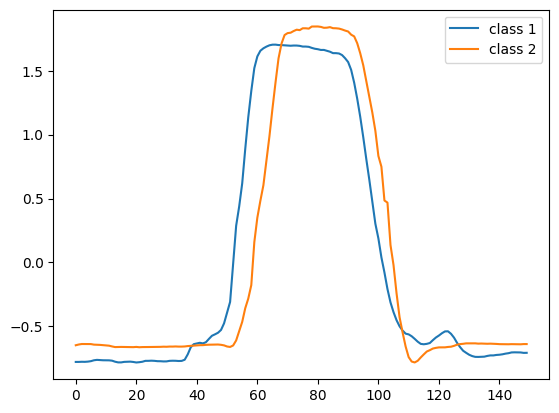

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
print('calss lables',classes)
print('train x',x_train.shape,'train lables', y_train.shape,
      'testx',x_test.shape,'test lables', y_test.shape)
plt.figure()
for c in classes:
 c_x_train = x_train[y_train == c]
 plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()



Библиотека SKTime использует различные форматы данных в задачах классификации.
Вы можете прочитать об этом в документации. Для преобразования данных из обычных
данных в набор для SKTime мы будем использовать функцию from_2d_array_to_nested из
sktime.utils.data_processing.
Примечание. Многие хранилища временных рядов используют собственные форматы
данных. Для преобразования формата данных вы можете использовать некоторые
утилиты, из tslearn.utils.

In [4]:
from tslearn.utils import from_pyts_dataset, to_sktime_dataset
X_train = to_sktime_dataset(from_pyts_dataset(x_train))
X_test = to_sktime_dataset(from_pyts_dataset(x_test))
X_train.head()



,dim_0
0,0 -0.647885 1 -0.641992 2 -0.63818...
1,0 -0.644427 1 -0.645401 2 -0.64705...
2,0 -0.778353 1 -0.778279 2 -0.77715...
3,0 -0.750060 1 -0.748103 2 -0.74616...
4,0 -0.599539 1 -0.597422 2 -0.59926...


In [9]:
!pip install --upgrade sktime


In [12]:
from sktime.datatypes import convert_to
X_train = convert_to(np.atleast_3d(x_train).transpose(0,2,1), to_type="nested_univ")
X_test  = convert_to(np.atleast_3d(x_test ).transpose(0,2,1), to_type="nested_univ")

In [13]:

X_train.head()

,var_0
0,0 -0.647885 1 -0.641992 2 -0.63818...
1,0 -0.644427 1 -0.645401 2 -0.64705...
2,0 -0.778353 1 -0.778279 2 -0.77715...
3,0 -0.750060 1 -0.748103 2 -0.74616...
4,0 -0.599539 1 -0.597422 2 -0.59926...


Исследование классификаторов

Методы пакета Sklearn
Для начала попробуем использовать классификатор SKlearn в качестве основы. Здесь мы
не будем использовать измененный формат данных. Если вы собираетесь использовать
вложенные данные SKTime в SKLearn, используйте from_nested_to_2d_arrayfrom
sktime.utils.data_processing или Tabularizer в конвейерах sklearn.

In [14]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9066666666666666

#Дерево временных рядов.

Дерево временных рядов представляет собой модификацию алгоритма дерева
классификации для временных рядов. В этом методе предлагается разбить выборку на
случайные интервалы, извлечь три признака (среднее, стандартное отклонение и
наклон) из каждого интервала, обучить дерево решений по извлеченным признакам.

In [16]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sklearn.tree import DecisionTreeClassifier
from sktime.utils.slope_and_trend import _slope
steps = [
 ("extract",
 RandomIntervalFeatureExtractor(
 n_intervals="sqrt",
 features=[np.mean, np.std, _slope])),
 ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.9

На самом деле мы можем использовать встроенный классификатор лес временных рядов
(TSF). TSF здесь представляет собой ансамбль древовидных классификаторов,
построенных на полученных статистиках по случайно выбранным интервалам. Для
каждого дерева интервалы выбираются случайным образом. Полное количество
интервалов √𝑠𝑒𝑟𝑖𝑒𝑠_𝑙𝑒𝑛𝑔𝑡ℎ. Из каждого из этих интервалов извлекаются среднее
значение, стандартное отклонение и наклон и объединяются в вектор признаков. Эти
новые функции затем используются для построения дерева, которое добавляется к
ансамблю.

In [19]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
tsf = TimeSeriesForestClassifier(n_estimators=100, random_state=47)
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9666666666666667

Классификатор на основе расстояния с динамическим искажением времени
(DTW)

Для временных рядов наиболее популярный алгоритм k-ближайших соседей основан на
измерении расстояния с динамическим искажением времени (DTW). Алгоритм DTW
состоит из следующих шагов:

 Вычислить расстояние между первой точкой в сегменте первом сегменте ряда и
каждой точкой во втором сегменте.

 Выберите минимум вычисленных значений и сохраните его (это этап
«деформации времени»).

 Перейдите ко второй точке и повторите этап 1.
 Двигайтесь шаг за шагом по точкам и повторяйте этап 1, пока не будут исчерпаны
все точки.

 Вычислите и выберите минимальное расстояние между первой точкой во втором
сегменте серии и каждой точкой в первой серии.

 Двигайтесь шаг за шагом по точкам во втором сегменте и повторяйте этап 3, пока
не будут исчерпаны все точки.

 Просуммируйте все сохраненные минимальные расстояния.

Алгоритм DTW формально можно описать как

\[
D(i, j) =
\begin{cases}
0 & \text{if } i = 0 \text{ or } j = 0 \\
dist(x_i, y_j) + \min\{D(i-1, j), D(i, j-1), D(i-1, j-1)\} & \text{otherwise}
\end{cases}
\]




\[ d_{DTW} = \min_i \sum_{j=0}^{K} D(i, j) \]


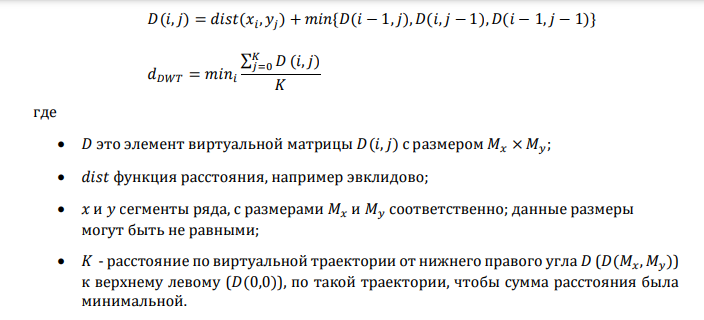

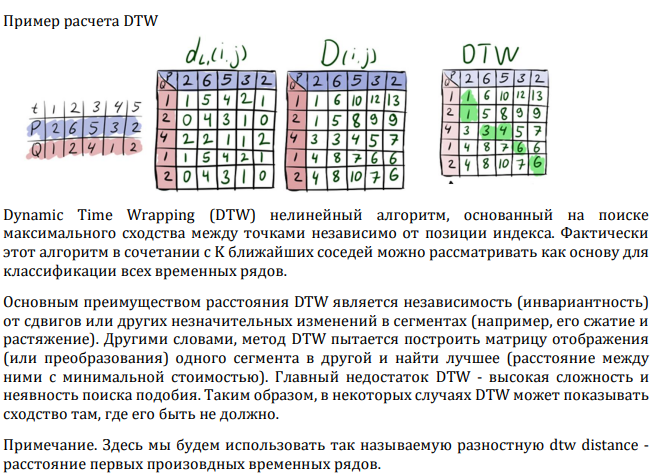

In [21]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9933333333333333